# PINNs on Graphs

This notebook accompanies the paper


---

In this notebook, we describe and illustrate the methodology proposed in the aforementioned paper.
Here, we deal with the solution of a drift-diffuion equation on a metric graph.
A metric graph is an undirected graph that consists of a set of vertices $\mathcal V$ and edges $\mathcal E$ where in contrast to combinatorial graphs a length $l_e$ is assigned to each edge $e \in \mathcal E$.
Each edge $e \in \mathcal E$ connects a pair of nodes $(v_{e_a},v_{e_b})$ with $v_{e_a}, v_{e_b} \in \mathcal V$

We consider the drift-diffusion equation posed on each edge

$$
\partial_t u = \partial_x ( \varepsilon \partial_x \rho_e - f(\rho_e) \partial_x V_e), \quad e \in \mathcal E
$$

where $\rho_e : [0,l_e] \times (0,T) \to \mathbb{R}_+$ describes, on each edge, the concentration of some quantity while $V_e: [0,l_e] \times(0,T)\to \mathbb{R}_+$ is a given potential and $\varepsilon > 0$ a given constant, typically small.

To make this a well-posed problem, we need a set of initial conditions as well as coupling conditions in the vertices.
- For vertices $v \in \mathcal V_{\mathcal K} \subset \mathcal V$, we apply homogeneous Neumann-Kirchhoff conditions, i.e., there holds
$$
\sum_{e \in \mathcal{E}_v} J_e \, n_{e} (v) = 0 \quad v \in \mathcal V_{\mathcal K},
$$
where we additionally ask the solution to be continuous over the edges, i.e.
$$
p_e(v) = p_{e^{'}}(v)
\quad \text{for all } v \in \mathcal{V}_{\mathcal K}, e, e^{'} \in \mathcal{E}_v
$$
with $\mathcal E_v$ the edge set incident to the vertex $v$.
- For vertices $v \in \mathcal V_{\mathcal D} := \mathcal V \setminus \mathcal{V}_{\mathcal K}$ the solution fulfills flux boundary conditions
$$
J_e \, n_e (v) = - \alpha_v \, (1-u_v) + \beta_v \, u_v \quad \text{for all } e \in \mathcal E_v.
$$

Import necessary packages.

In [1]:
import tensorflow as tf
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt
import networkx as netx
from time import time
DTYPE='float64'
timestepmode = 'implicit'
tf.keras.backend.set_floatx(DTYPE)

## Set up class GraphPINNs

Next, we define the class `GraphPINN`, which is employed in the subsequent code.
The idea is to have one vanilla `PINN` for each edge which are connected via boundary and vertex conditions which are enforced weakly.

---

First, we define the model for a `PINN` which consists of one scaling layer, a number of fully connected hidden layers and one final output layer.

In [2]:
# Define model architecture
class PINN(tf.keras.Model):
    """ Set basic architecture of the PINN model."""

    def __init__(self, lb, ub,
                 output_dim=1,
                 num_hidden_layers=3,
                 num_neurons_per_layer=20,
                 activation='tanh',
                 kernel_initializer='glorot_normal',
                 **kwargs):
        
        super().__init__(**kwargs)

        self.num_hidden_layers = num_hidden_layers
        self.input_dim = lb.shape[0]
        self.output_dim = output_dim
        self.lb = lb
        self.ub = ub

        # Define NN architecture
        
        # Scaling layer to map input to the interval [-1, 1]
        #self.scale = tf.keras.layers.Lambda(
        #    lambda x: 2.0 * (x - lb) / (ub - lb) - 1.0)
        
        # Inititialize num_hidden_layers many fully connected dense layers
        self.hidden = [tf.keras.layers.Dense(num_neurons_per_layer,
                                             activation=tf.keras.activations.get(
                                                 activation),
                                             kernel_initializer=kernel_initializer) for _ in range(self.num_hidden_layers)]
        
        # Output layer
        #self.out = tf.keras.layers.Dense(output_dim, activation=None)
        self.out = tf.keras.layers.Dense(output_dim, activation='sigmoid')
        
    def call(self, X):
        """Forward-pass through neural network."""
        
        #Z = self.scale(X)
        Z = X
        
        for i in range(self.num_hidden_layers):
            Z = self.hidden[i](Z)
            
        return self.out(Z)

In this notebook, we rely on the package [NetworkX](https://networkx.org/).
An alternative approach would be to employ [igraph](https://igraph.org/), which seems to be more lightweight.

Next, we set up the class for a graph PINN which takes either an adjacency matrix $A$ or a `MultiDiGraph` as input `inp` to define the network as well as the Dirichlet data as a list of pairs $(i, u_i)_{i=1}^{n_D}$ corresponding to $u(v_i) = u_i$.
*Notes*:
- we define our graph as a `MultiDiGraph` since graphs imported from [OpenStreetMap](https://www.openstreetmap.de/) obey this format.

### Examples

First, we define a network which is determined by its
adjacency matrix $A \in \mathbb{R}_+^{n_v \times n_v}$ with $n_v$ the number of vertices.
Note that this matrix is not symmetric, as it belongs to a *directed* graph.
Here, an entry $a_{i,j} > 0$ indicates that there is an edge starting in vertex $i$ and ending in vertex $j$ with length $a_{i,j}$.

In [3]:
adj = 5
# Specify adjacency matrix
if adj == 1:
    A = np.array([[0, 1, 0, 0, 0, 0, 0, 0],
                 [0, 0, 1, 0, 1, 0, 0, 0],
                 [0, 0, 0, 1, 1, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 1, 0],
                 [0, 0, 0, 0, 0, 1, 0, 0],
                 [0, 0, 0, 0, 0, 0, 1, 0],
                 [0, 0, 0, 0, 0, 0, 0, 1],
                 [0, 0, 0, 0, 0, 0, 0, 0]
                ], dtype=np.int16)
    # Set boundaries
    tmin = 0.
    tmax = 1.
    xmin = 0.
    xmax = 0.1
    
    u0 = lambda x : 0
    dirichletNodes = np.array([0, 7])
    dirichletAlpha = np.zeros(8)
    dirichletBeta = np.zeros(8)
    dirichletAlpha[0] = .8
    dirichletBeta[7] = .5
                              
    
    eps = 0.01
    def f(u):
        return u * (1-u)
    
    def df(u):
        return 1 - 2*u
    
    def pde(u, ut, ux, uxx):
        return ut - eps * uxx + df(u) * ux
    
    def flux(u, ux):
        return -eps * ux + f(u)

    def initial_cond(x):
        return np.zeros_like(x)
    
elif adj == 2:
    
    A = np.array([[0, 1],
                 [0, 0]], dtype=np.int16)
    pos = np.array([[0,0],[1,0]])
    
    # Set boundaries
    tmin = 0.
    tmax = 10.
    xmin = 0.
    xmax = 1.
    
    eps = .01

    dirichletNodes = np.array([0, 1])
    dirichletAlpha = np.array([0.7, 0.0])
    dirichletBeta = np.array([0.0, 0.8])
    
    def f(u):
        return u * (1-u)
    
    def df(u):
        return 1 - 2*u
    
    def pde(u, ut, ux, uxx):
        return ut - eps * uxx + df(u) * ux
    
    def flux(u, ux):
        return -eps * ux + f(u)
    
    def initial_cond(x):
        return tf.zeros_like(x)
    
elif adj == 5:
    A = np.array([[0, 0, 1, 0, 0, 0],
                  [0, 0, 1, 0, 0, 0],
                  [0, 0, 0, 1, 0, 0],
                  [0, 0, 0, 0, 1, 1],
                  [0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0]], dtype=np.int16)
    
    pos = np.array([[0.0, 0.0],
                [0.0, 1.0],
                [0.5, 0.5],
                [0.5+np.sqrt(2)/2, 0.5],
                [1.0+np.sqrt(2)/2, 0.0],
                [1.0+np.sqrt(2)/2, 1.0]])
    # Set boundaries
    tmin = 0.
    tmax = 10.
    xmin = 0.
    xmax = 1.
    
    dirichletNodes = np.array([0, 1, 4, 5])
    # Changed this!
    dirichletAlpha = np.array([0.9, 0.3, 0., 0., 0., 0.])
    dirichletBeta = np.array([0.0, 0.0, 0., 0., 0.8, 0.1])
                              
    eps = 1e-2
    def f(u):
        return u * (1-u)
    
    def df(u):
        return 1 - 2*u
    
    def pde(u, ut, ux, uxx):
        return ut - eps * uxx + df(u) * ux
    
    def flux(u, ux):
        return -eps * ux + f(u)
    
    def initial_cond(x):
        return np.zeros_like(x)


# Lower bounds
lb = np.array([tmin, xmin], dtype=DTYPE)

# Upper bounds
ub = np.array([tmax, xmax], dtype=DTYPE)

In [4]:
class Graph():
    
    def __init__(self, inp, dirichletNodes, dirichletAlpha, dirichletBeta, lb, ub, pos=None):
        
        if isinstance(inp, netx.classes.multidigraph.MultiGraph):
            self.G = inp
            self.A = netx.adjacency_matrix(G).toarray()
            
        else:
            # Store adjacency matrix
            self.A = A
            # Define networkx multigraph
            self.G = netx.MultiDiGraph(A)
        
        self.dirichletNodes = dirichletNodes
        self.dirichletAlpha = dirichletAlpha
        self.dirichletBeta = dirichletBeta
        
        self.lb = lb
        self.ub = ub
        
        # Get number of vertices
        self.n_v = self.A.shape[0]
        
        # Determine lists of edges and lengths
        self._determineEdgeList()
        
        # Determine list of vertices and incoming as well as outgoing edges
        self._determineVertexList()
        
        # Determine graph layout if necessary
        if pos is None:
            self.pos = netx.kamada_kawai_layout(self.G)
        else:
            if isinstance(pos, np.ndarray):
                self.pos = self.pos_array_to_dict(pos)
            else:
                raise ValueError('Check pos argument.')
        
    def _determineEdgeList(self):
        """Determine edge matrix and weight vector.
        This could also be accomplished by a loop over `G.edges`:
            for e in G.edges:
                print(e)
        """
        
        self.E = []
        self.W = []
        
        for i in range(self.n_v):
            for j in range(i + 1, self.n_v):
                aij = self.A[i, j]
                if aij > 0:
                    #print('Connectivity between i: {} and j: {}'.format(i,j))
                    self.E.append([i, j])
                    self.W.append(aij)

        # Get number of edges
        self.ne = len(self.E)
        
    def _determineVertexList(self):
        
        self.Vin = [[] for _ in range(self.n_v)]
        self.Vout = [[] for _ in range(self.n_v)]
        
        self.inflowNodes = []
        self.outflowNodes = []        
        
        for i, e in enumerate(self.E):
            # Unpack edge
            vin, vout = e
            self.Vin[vout].append(i)
            self.Vout[vin].append(i)
            
        for i in range(self.n_v):
            if self.Vin[i] and (not self.Vout[i]):
                self.outflowNodes.append(i)

            if (not self.Vin[i]) and self.Vout[i]:
                self.inflowNodes.append(i)
        self.outflowNodes = np.array(self.outflowNodes)
        self.inflowNodes = np.array(self.inflowNodes)
        self.innerVertices = np.setdiff1d(np.arange(self.n_v), self.dirichletNodes)
            
    def plotGraph(self, **kwargs):

        netx.draw(self.G, pos=self.pos, with_labels=True, **kwargs)
    
    def pos_array_to_dict(self, pos):
        pos_dict = dict()
        for i in range(pos.shape[0]):
            pos_dict[i] = pos[i,:]
        return pos_dict

Vin: [[], [], [0, 1], [2], [3], [4]]
Vout: [[0], [1], [2], [3, 4], [], []]
inner vertices [2 3]


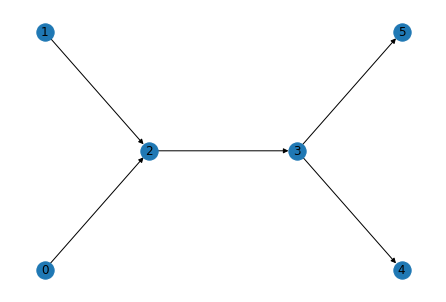

In [6]:
%matplotlib inline

graph = Graph(A, dirichletNodes, dirichletAlpha, dirichletBeta, lb, ub, pos)
graph.plotGraph()
print('Vin:', graph.Vin)
print('Vout:', graph.Vout)
print('inner vertices', graph.innerVertices)


Draw collocation points uniformly or take them equidistantly distributed.

In [7]:
mode = 'deterministic'
#mode = 'uniform'

N_0 = 200
N_b = 1000
N_r = 100
if timestepmode == 'implicit':
    if mode == 'deterministic':
        t_r = tf.linspace(lb[0], ub[0], N_b + 1)
        #t_r = tf.cast(tf.linspace(lb[0], ub[0], N_b + 1), DTYPE)
        #x_r = tf.cast(tf.linspace(lb[1], ub[1], N_0 + 1), DTYPE)
        x_r = tf.linspace(lb[1], ub[1], N_0 + 1)
        x_r = tf.reshape(x_r, (-1,1))
    elif mode == 'uniform':
        t_r = tf.linspace(lb[0], ub[0], N_b + 1)
        x_r = tf.random.uniform((N_0, 1), lb[1], ub[1], dtype=DTYPE)    
        x_r = tf.reshape(x_r, (-1,1))
else: 
    if mode == 'deterministic':

        # Uniform distributed collocation points
        t_r = tf.linspace(lb[0], ub[0], N_b+1)
        x_r = tf.linspace(lb[1], ub[1], N_0+1)
        tt, xx = tf.meshgrid(t_r,x_r)
        X_r = tf.concat([tf.reshape(tt,(-1,1)), tf.reshape(xx,(-1,1))], axis=1)

    elif mode == 'uniform':

        # Set random seed for reproducible results
        tf.random.set_seed(0)

        X_r = tf.random.uniform((N_r,2), lb, ub, dtype=DTYPE)

        # Draw uniform sample points for initial boundary data
        t_0 = tf.ones((N_0,1), dtype=DTYPE)*lb[0]
        x_0 = tf.random.uniform((N_0,1), lb[1], ub[1], dtype=DTYPE)
        X_0 = tf.concat([t_0, x_0], axis=1)

        # Boundary data
        t_b = tf.random.uniform((N_b,1), lb[0], ub[0], dtype=DTYPE)
        x_l = tf.ones((N_b,1), dtype=DTYPE) * lb[1]
        X_l = tf.concat([t_b, x_l], axis=1)

        x_u = tf.ones((N_b,1), dtype=DTYPE) * ub[1]
        X_u = tf.concat([t_b, x_u], axis=1)

        X_b = tf.concat([X_l, X_u], axis=0)

        # Draw uniformly sampled collocation points
        t_r = tf.random.uniform((N_r,1), lb[0], ub[0], dtype=DTYPE)
        x_r = tf.random.uniform((N_r,1), lb[1], ub[1], dtype=DTYPE)
        X_r = tf.concat([t_r, x_r], axis=1)
        X_data = tf.concat([X_0, X_b, X_r], axis=0)
        
    # Draw collocation points
    fig = plt.figure(figsize=(7, 5))
    ax = fig.add_subplot(111)
    ax.scatter(X_r[:,0].numpy(), X_r[:,1].numpy(),color='red',alpha=0.3)
    ax.scatter(X_0[:,0].numpy(), X_0[:,1].numpy(), color='blue', alpha=0.5)
    ax.scatter(X_b[:,0].numpy(), X_b[:,1].numpy(), color='cyan', alpha=0.5)
    ax.set_xlabel('t')
    ax.set_ylabel('x')
    
print('Time step size: ', t_r[1].numpy() - t_r[0].numpy())

Time step size:  0.01


## Fully implicit time stepping scheme

In [8]:
class TimesteppingPINNSolver(object):
    def __init__(self, graph, t_r, x_r):
        
        self.graph = graph
        self.ne = self.graph.ne
        
        self._setupNNs()
        
        self.t = t_r
        self.x = x_r
        self.dt = t_r[1].numpy() - t_r[0].numpy()
        
        self.nx = x_r.shape[0]
        self.nt = t_r.shape[0]

        # Initialize history of losses and global iteration counter
        self.hist = []
        self.iter = 0
        self.current_loss = 999.
        
        self.idx = 1
        
        self.U = []
        self.uold = []
        for i in range(self.ne):
            self.uold.append(tf.Variable(initial_cond(self.x)[:, 0]))
            self.U.append(1e5*np.ones(shape=(self.nt ,self.nx)))
            self.U[i][0, :] = self.uold[i].numpy()
            
        # Call each network once to initialize trainable variables
        self.trainable_variables = []
        for i in range(self.ne):
            self.NNs[i](tf.constant([[1.]], dtype=DTYPE))
            self.trainable_variables.append(self.NNs[i].trainable_variables)
            
        # Setup auxiliary variables for vertex values to ensure continuity
        self._setupVertexVariables()
        
        for i, v in enumerate(self.graph.innerVertices):
            self.trainable_variables.append([self.vertexVals[i]])
        
        self.nvar = len(self.trainable_variables)
        
    def _setupNNs(self):
        
        self.NNs = []
        for i, e in enumerate(self.graph.E):
            self.NNs.append(PINN(lb=self.graph.lb, ub=self.graph.ub))
    
        print('Initialized {:d} neural nets.'.format(len(self.NNs)))
            

    def _setupVertexVariables(self):
        
        self.vertexVals = []
        for _ in self.graph.innerVertices:
            # self.vertexVals.append(tf.Variable(tf.random.uniform(shape=(self.nb,)), trainable=True, dtype=DTYPE))
            self.vertexVals.append(tf.Variable(tf.random.uniform(shape=(1,), dtype=DTYPE), trainable=True))
    
    def _fvals0(self, x):

        # Initialize lists for values and derivatives
        u = []
        for i in range(self.ne):
            u.append(self.NNs[i](x)[:,0])

        return u
    
    def _fvals1(self, x):
        
        # Initialize lists for values and derivatives
        u = []
        ux = []
        
        for i in range(self.ne):
            
            with tf.GradientTape(persistent=True) as tape:
                # Watch variables representing t and x during this GradientTape
                tape.watch(x)

                # Compute current values u(t,x)
                u.append(self.NNs[i](x)[:, 0])
            ux.append(tape.gradient(u[i], x)[:, 0])
            
            del tape
                
        return u, ux
    
    def _fvals2(self, x):
        
        # Initialize lists for values and derivatives
        u = []
        ux = []
        uxx = []
        
        for i in range(self.ne):
            
            with tf.GradientTape(persistent=True) as tape:
                # Watch variables representing t and x during this GradientTape
                tape.watch(x)

                # Compute current values u(t,x)
                u.append(self.NNs[i](x)[:, 0])
                ux.append(tape.gradient(u[i], x)[:, 0])
                
            uxx.append(tape.gradient(ux[i], x)[:, 0])
            
            del tape
                
        return u, ux, uxx

    def determine_losses(self):
        
        # Short-hand notation of mean-squared loss
        mse = lambda x : tf.reduce_mean(tf.square(x))
        #mse = lambda x : tf.reduce_sum(tf.square(x))

        
        ###################################
        ### Residual loss for all edges ###
        ###################################
        u, ux, uxx = self._fvals2(self.x)
        
        loss_res = 0
        for i in range(self.ne):
            #res_e = u[i] - self.U[i][self.idx-1, :] + self.dt * pde(u[i], 0., ux[i], uxx[i])
            #print(u[i])
            res_e = u[i] - self.uold[i] + self.dt * pde(u[i], 0., ux[i], uxx[i])

            #print(self.U[i][self.idx-1, :])
            #loss_res += mse(res_e[1:-1])
            loss_res += mse(res_e)

            #print(mse(res_e))
            #print(self.U[i][self.idx-1, :])
        
        ###################################
        ###   Continuity in vertices    ###
        ###################################
        
        # ul, ult, ulx = self._fvals1(self.Xl[:,0], self.Xl[:,1])
        # uu, uut, uux = self._fvals1(self.Xu[:,0], self.Xu[:,1])
        loss_cont = 0
        
        for i, v in enumerate(self.graph.innerVertices):
            
            for j in self.graph.Vin[v]:
                val = u[j][-1] - self.vertexVals[i]
                loss_cont += mse(val)

            for j in self.graph.Vout[v]:
                val = u[j][0] - self.vertexVals[i]
                loss_cont += mse(val)
                
        #####################################
        ### Kirchhoff-Neumann in vertices ###
        #####################################
        
        # Kirchhoff-Neumann condition in center nodes
        loss_KN = 0
        for i in self.graph.innerVertices:
            
            val = 0
            #print('Kirchhoff-Neumann in node ', i)
            for j in self.graph.Vin[i]:
                #print('incoming edge:', j)
                val += flux(u[j][-1], ux[j][-1])
                #val += flux(uu[j], uux[j])
                
            for j in self.graph.Vout[i]:
                #print('outgoing edge:', j)
                val -= flux(u[j][0], ux[j][0])
                #val -= flux(ul[j], ulx[j])
            loss_KN += mse(val)
        
        #####################################
        ###      Inflow/Outflow conds     ###
        #####################################
        
        loss_D = 0
        for i, v in enumerate(self.graph.dirichletNodes):
            
            #TODO
            alpha = self.graph.dirichletAlpha[v]
            beta = self.graph.dirichletBeta[v]
            
            print('\nin node ', v, 'alpha ', alpha, 'beta ', beta)
            val = 0
            #print('\n', val)
            for j in self.graph.Vin[v]:
                print('outflow: ', j)
                #val += -flux(uu[j], uux[j]) - beta * (uu[j])
                val += flux(u[j][-1], ux[j][-1]) - beta * (u[j][-1])
                #loss_D += mse(val)
            #print(val)
                

            for j in self.graph.Vout[v]:
                print('inflow: ', j)
                #val += -flux(ul[j], ulx[j]) + alpha * (1-ul[j])
                val += -flux(u[j][0], ux[j][0]) + alpha * (1.-u[j][0])
                #val += -flux(ul[j], ulx[j]) + alpha * (1-ul[j])
                #loss_D += mse(val)
            #print(val, '\n')
            loss_D += mse(val)
            
        return loss_res, loss_cont, loss_KN, loss_D
    
    def loss_fn(self):
        
        loss_res, loss_cont, loss_KN, loss_D = self.determine_losses()
        
        loss = loss_res + loss_cont + loss_KN + loss_D
        #print(loss_res)
        #print(loss_cont)
        #print(loss_KN)
        #print(loss_D)
        #print(loss)
        return loss
    
    @tf.function
    def get_grad(self):
        with tf.GradientTape(persistent=True) as tape:
            # This tape is for derivatives with
            # respect to trainable variables
            tape.watch(self.trainable_variables)
            loss = self.loss_fn()

        g = tape.gradient(loss, self.trainable_variables)
        del tape

        return loss, g
    
    
            
    def solve_with_TFoptimizer(self, optimizer, eps, N=1001):
        """This method performs a gradient descent type optimization."""
        
        self.callback_init()
        
        for i in range(N):
            loss, g = self.get_grad()
            # Perform gradient descent step
            for j in range(self.nvar):
                optimizer.apply_gradients(zip(g[j], self.trainable_variables[j]))
            #print(self.current_loss)
            self.current_loss = loss.numpy()
            #print(self.current_loss)
            #print(loss)
            #print('\n')

            self.callback()
            
            if self.current_loss < eps:
                break
                
    def solve_with_ScipyOptimizer(self, method='L-BFGS-B', **kwargs):
        """This method provides an interface to solve the learning problem
        using a routine from scipy.optimize.minimize.
        (Tensorflow 1.xx had an interface implemented, which is not longer
        supported in Tensorflow 2.xx.)
        Type conversion is necessary since scipy-routines are written in
        Fortran which requires 64-bit floats instead of 32-bit floats."""

        def get_weight_tensor():
            """Function to return current variables of the model
            as 1d tensor as well as corresponding shapes as lists."""

            weight_list = []
            shape_list = []

            # Loop over all variables, i.e. weight matrices, bias vectors
            # and unknown parameters
            for i in range(len(self.trainable_variables)):
                for v in self.trainable_variables[i]:
                    shape_list.append(v.shape)
                    weight_list.extend(v.numpy().flatten())

            weight_list = tf.convert_to_tensor(weight_list)
            return weight_list, shape_list


        x0, shape_list = get_weight_tensor()

        def set_weight_tensor(weight_list):
            """Function which sets list of weights
            to variables in the model."""
            idx = 0

            for i in range(len(self.trainable_variables)):
                for v in self.trainable_variables[i]:
                    vs = v.shape

                    # Weight matrices
                    if len(vs) == 2:
                        sw = vs[0] * vs[1]
                        new_val = tf.reshape(
                            weight_list[idx:idx + sw], (vs[0], vs[1]))
                        idx += sw

                    # Bias vectors
                    elif len(vs) == 1:
                        new_val = weight_list[idx:idx+vs[0]]
                        idx += vs[0]

                    # Variables (in case of parameter identification setting)
                    elif len(vs) == 0:
                        new_val = weight_list[idx]
                        idx += 1

                    # Assign variables (Casting necessary since scipy requires float64 type)
                    v.assign(tf.cast(new_val, DTYPE))

        def get_loss_and_grad(w):
            """Function that provides current loss and gradient
            w.r.t the trainable variables as vector. This is mandatory
            for the LBFGS minimizer from tfp.optimizer."""

            # Update weights in model
            set_weight_tensor(w)
            # Determine value of \phi and gradient w.r.t. \theta at w
            loss, grad = self.get_grad()
            # Flatten gradient
            grad_flat = []
            for i in range(len(self.trainable_variables)):
                for g in grad[i]:
                    grad_flat.extend(g.numpy().flatten())

            # Store current loss for callback function
            #print(self.current_loss)
            self.current_loss = loss
            #print(self.current_loss)

            # Return value and gradient of \phi as tuple
            return loss.numpy().astype(np.float64), np.array(grad_flat, dtype=np.float64)

        self.callback_init()

        return scipy.optimize.minimize(fun=get_loss_and_grad,
                                       x0=x0,
                                       jac=True,
                                       method=method,
                                       callback=self.callback,
                                       **kwargs)
    
                
    def ts_scheme(self, eps=1e-6):
        max_trials = 1
        while self.idx < 20: #self.nt:
            print('Solve time step {}/{}\n'.format(self.idx, self.nt))
            
            trial = 0
            while trial < max_trials:
                
                print('Adam...\n')
                
                if self.idx == 1:
                    lr = 0.01
                    optim = tf.keras.optimizers.Adam(learning_rate=lr)
                    self.solve_with_TFoptimizer(optim, eps=eps, N=4001)
                    
                else:
                    lr = 0.001
                    optim = tf.keras.optimizers.Adam(learning_rate=lr)
                    self.solve_with_TFoptimizer(optim, eps=eps, N=501)
                self.callback(force=True)
                print('LBFGS...\n')
                ret = self.solve_with_ScipyOptimizer(options={'maxiter': 50000,
                                     'maxfun': 50000,
                                     'maxcor': 50,
                                     'maxls': 50,
                                     'eps': eps,
                                     'ftol': 1.0e3*np.finfo(float).eps,
                                     'gtol': 1.0e3*np.finfo(float).eps})
                # factr is 10000000 
                print(ret.message)
                trial += 1
                self.callback(force=True)
            
            u = self._fvals0(self.x)
            self.assign_u(self.idx, u)
            self.idx += 1
            self.iter = 0

    def assign_u(self, timestep, u):
        
        for i in range(self.ne):
            #print('assign new u to timestep {}'.format(timestep))
            #print(u[i].shape)
            self.uold[i].assign(u[i])
            self.U[i][timestep, :] = u[i]
            
    def next_step(self):
        u = self._fvals0(self.x)
        self.assign_u(self.idx, u)
        self.idx += 1

        
    def callback_init(self):
        self.t0 = time()
        print(' Iter            Loss    Time')
        print('-----------------------------')
    
    def callback(self, xr=None, force=False):
        if self.iter % 100 == 0 or force:
            print('{:05d}  {:10.8e}   {:4.2f}'.format(
                self.iter, self.current_loss, time() - self.t0))
        self.hist.append(self.current_loss)
        self.iter += 1
        
    def plot_loss_history(self, ax=None):
        if not ax:
            fig = plt.figure(figsize=(7, 5))
            ax = fig.add_subplot(111)
        ax.semilogy(range(len(self.hist)), self.hist, 'k-')
        ax.set_xlabel('$n_{epoch}$')
        ax.set_ylabel('$\\phi^{n_{epoch}}$')
        return ax

In [10]:
%%time
tf.random.set_seed(0)
#gPINN = GraphPINN(A, dirichletNodes, dirichletAlpha, dirichletBeta, lb, ub)
solver = TimesteppingPINNSolver(graph, t_r, x_r)
solver.determine_losses()
#1.0*np.finfo(float).eps
#u0 = solver._fvals0(x_r)
#u1, u1x = solver._fvals1(x_r)
#u2, u2x, u2xx = solver._fvals2(x_r)
#print(u1)
#print(u1x)
#print([u2[i]-u0[i] for i in range(gPINN.ne)])
#print([u2x[i]-u1x[i] for i in range(gPINN.ne)])
#print(u2xx)
#solver.determine_losses()

#lr = 0.01
#optim = tf.keras.optimizers.Adam(learning_rate=lr)
#print('Start with TF optimizer\n')
#solver.solve_with_TFoptimizer(optim, N=5001)
solver.ts_scheme(1e-6)

Initialized 5 neural nets.

in node  0 alpha  0.9 beta  0.0
inflow:  0

in node  1 alpha  0.3 beta  0.0
inflow:  1

in node  4 alpha  0.0 beta  0.8
outflow:  3

in node  5 alpha  0.0 beta  0.1
outflow:  4
Solve time step 1/1001

Adam...

 Iter            Loss    Time
-----------------------------

in node  0 alpha  0.9 beta  0.0
inflow:  0

in node  1 alpha  0.3 beta  0.0
inflow:  1

in node  4 alpha  0.0 beta  0.8
outflow:  3

in node  5 alpha  0.0 beta  0.1
outflow:  4
00000  2.09564450e+00   1.59
00100  3.29135123e-03   3.09
00200  1.71436874e-03   4.64
00300  7.83623621e-04   6.20
00400  5.00138516e-04   7.70
00500  4.06101810e-03   9.33
00600  1.11714002e-03   11.17
00700  7.60346457e-04   12.98
00800  2.91758307e-03   14.79
00900  2.23761842e-04   16.79
01000  3.66989545e-04   18.76
01100  2.59708115e-04   20.72
01200  5.91762070e-04   22.57
01300  1.82151841e-04   24.53
01400  6.56669579e-04   26.33
01500  1.24851648e-04   28.12
01600  1.92728475e-04   30.01
01700  2.08515405e-0

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
00075  1.29207538e-08   0.68
Wall time: 2min 35s


In [11]:
# Wall time: 7min 53s
# Wall time: 1min 6s


#solver.determine_losses()
solver.loss_fn()


in node  0 alpha  0.9 beta  0.0
inflow:  0

in node  1 alpha  0.3 beta  0.0
inflow:  1

in node  4 alpha  0.0 beta  0.8
outflow:  3

in node  5 alpha  0.0 beta  0.1
outflow:  4


<tf.Tensor: shape=(), dtype=float64, numpy=4.4357873503401354e-05>

In [13]:
%matplotlib inline
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

#Nt = 60
#Nx = 120

#tspace = tf.linspace(lb[0], ub[0], Nt + 1)
#xspace = tf.reshape(tf.linspace(lb[1], ub[1], Nx + 1), [-1, 1])

pos = solver.graph.pos
xy_list = [pos[e[0]] + x_r*(pos[e[1]] - pos[e[0]]) / (ub[1]-lb[1]) for e in solver.graph.E]

def plot_network(j=0, fig=None):
    if not fig:
        fig = plt.figure(1, clear=True)
    else:
        fig.clf()
        
    ax = fig.add_subplot(1,1,1, projection='3d')
    
    for i, e in enumerate(solver.graph.E):
        u = solver.U[i][j, :]
        ax.plot(xy_list[i][:,0], xy_list[i][:,1], u)
    
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlim([.0,1.0])
    ax.view_init(12, 135)

#fig.canvas.layout.width = '100%'
#fig.canvas.layout.height = '900px'
j_slider = widgets.IntSlider(min=0,max=N_b,step=1)


fig = plt.figure(figsize=(12, 6))
def interactive_net(j=0):
    plot_network(j, fig)
    
interactive_plot = interactive(interactive_net, j=j_slider)
output = interactive_plot.children[-1]
#output.layout.height = '350px'
interactive_plot
#u = plot_network(4)

interactive(children=(IntSlider(value=0, description='j', max=1000), Output()), _dom_classes=('widget-interact…

<Figure size 864x432 with 0 Axes>

In [14]:
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import matplotlib.animation as animation


#def update_line(num, data, line):
#    line.set_data(data[..., :num])
#    return line,

# Set up formatting for the movie files
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Jan Blechschmidt'), bitrate=1800)

fig = plt.figure(figsize=(16, 10))

line_ani = animation.FuncAnimation(fig, interactive_net, 200, interval=50)
line_ani.save('sol_pinn.mp4', writer=writer)

#fig2 = plt.figure()

#x = np.arange(-9, 10)
#y = np.arange(-9, 10).reshape(-1, 1)
#base = np.hypot(x, y)
#ims = []
#for add in np.arange(15):
#    ims.append((plt.pcolor(x, y, base + add, norm=plt.Normalize(0, 30)),))

#im_ani = animation.ArtistAnimation(fig2, ims, interval=50, repeat_delay=3000,
#                                   blit=True)
#im_ani.save('im.mp4', writer=writer)

RuntimeError: Requested MovieWriter (ffmpeg) not available